In [21]:
import numpy
import os
import psutil
import gc
import re
import random
import csv
import numpy
import collections
import matplotlib.pyplot as matplotlib
import matplotlib.patches as mpatches
import logging
from __future__ import division
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn import svm
from sklearn.svm import SVC

from sklearn.metrics import r2_score

# Utilities Classes Here

In [22]:
class SupportedFileTypes:
    JSON = "json"
    MATLAB = "m"
    OCTAVE = "octave"
    TXT = "txt"
    R = "r"

In [23]:
class SupportedDistributions:
    DISCRETE = "discrete"
    GAUSS = "gauss"
    UNIFORM = "uniform"
    GAMMA = "gamma"
    LOGNORMAL = "lognormal"
    BINOMIAL = "binomial"
    POISSON = "poisson"
    BOOLEAN = "boolean"

In [24]:
class SupportedAnalysisTypes:
    CLASSIFICATION = "CLASSIFICATION"
    REGRESSION = "REGRESSION"

In [25]:
class SafeCastUtil(object):

    @staticmethod
    def safeCast(val, to_type, default=None):
        try:
            return to_type(val)
        except (ValueError, TypeError):
            return default

    @staticmethod
    def getMatrixShapeNullSafe(matrix):
        matrix_shape = matrix.shape
        if len(matrix_shape) == 1:
            return matrix_shape[0], 1
        elif len(matrix_shape) > 1:
            return matrix_shape
        else:
            return 0, 0

In [26]:
class GarbageCollectionUtility(object):

    @staticmethod
    def logMemoryUsageAndGarbageCollect(log):
        processes = psutil.Process()
        procs = [processes] + processes.children(recursive=True)
        for process in procs:
            rss = process.memory_info().rss
            memory_usage_mb = numpy.round(rss / 1e6, 2)
            log.info("Memory usage for PID %s: %s: MB", process.pid, memory_usage_mb)
        gc.collect()

In [27]:
class OperatingSystemUtil(object):

    @staticmethod
    def changeWorkingDirectory(new_directory):
        if not os.path.isdir(new_directory):
            os.mkdir(new_directory)
        os.chdir(new_directory)

In [28]:
class FileProcessingService(object):

    GENERATED_FOLDER_NAME = "/GenomeFiles"
    GENOMES_FILE_NAME = "Genomes.txt"
    IDENTIFIER_REGEX = re.compile(r'\$.+?\$')
    DEFAULT_GAUSSIAN_STANDARD_DEVIATION = 0.1
    OUTPUT_FILE_NAME = "Sim0GenomesMatrix.csv"

    DEFAULT_NUM_GENOMES = 10

    num_generated_coefficients = 0

    def __init__(self, data_file, file_type, number_of_genomes, path):
        self.data_file = data_file
        self.file_type = file_type
        self.number_of_genomes = SafeCastUtil.safeCast(number_of_genomes, int, self.DEFAULT_NUM_GENOMES)
        self.path = path

    def createGenomes(self):
        if self.file_type == SupportedFileTypes.MATLAB or self.file_type == SupportedFileTypes.OCTAVE:
            return self.handleFile("%")
        elif self.file_type == SupportedFileTypes.R:
            return self.handleFile("#")
            # Note - fn will need to be able to take in files containing booleans

    def handleFile(self, comment_character, file_name_root="genome"):
        genomes_file_list = []

        path = self.maybeCreateNewFileDirectory()

        genomes = collections.OrderedDict()
        for genome in range(1, self.number_of_genomes + 1):
            genome_name = file_name_root + str(genome) #Note - changed this to a parameter for SIM1
            coefficient_map = collections.OrderedDict()
            new_genome_file = open(path + "/" + genome_name + "." + self.file_type, "w")
            genomes_file_list.append(genome_name + "." + self.file_type)

            for line in self.data_file:
                if line[0] == comment_character:
                    new_genome_file.write(line)
                    continue
                new_line = self.maybeGenerateNewLineAndSaveCoefficientValues(coefficient_map, line)
                new_genome_file.write(new_line)
            new_genome_file.close()

            self.data_file.seek(0)
            self.num_generated_coefficients = 0
            genomes[genome_name] = coefficient_map

        self.writeGenomesKeyFilesToDirectory(genomes, path)
        genomes_matrix = self.createGenomesMatrix(genomes)
        self.writeDataFile(genomes_matrix)
        return [genomes_file_list, genomes_matrix]

    def maybeCreateNewFileDirectory(self):
        target_directory = self.path + self.GENERATED_FOLDER_NAME
        if os.getcwd() != "/":
            if not os.path.isdir(target_directory):
                os.mkdir(target_directory)
        else:
            raise ValueError('Provided path must not be root directory.')
        return target_directory

    def maybeGenerateNewLineAndSaveCoefficientValues(self, coefficient_map, line):
        target_sequences = self.extractTargetSequences(line)
        new_line = line
        for i in range(0, len(target_sequences)):
            target_sequence = target_sequences[i]
            coefficient_name = self.extractCoefficientName(target_sequence)
            distribution = self.extractDistributionName(target_sequence)
            params = self.extractParameters(target_sequence)
            coefficient_value = self.retrieveCoefficientValueFromDistribution(distribution, params)

            # Replace $dollar sign contents$ with extracted coefficient value, write to file
            new_line = new_line.replace("$" + target_sequence + "$", str(coefficient_value), 1)
            if type(coefficient_value) is str:
                coefficient_value = self.replaceCoefValue(coefficient_value)
            coefficient_map[coefficient_name] = coefficient_value
        return new_line

    def extractTargetSequences(self, line):
        return [target_sequence.replace("$", "") for target_sequence in self.IDENTIFIER_REGEX.findall(line)]

    def extractCoefficientName(self, target_sequence):
        if "name=" in target_sequence:
            return target_sequence.split("name=")[1].strip()
        else:
            self.num_generated_coefficients += 1
            return "coefficient" + str(self.num_generated_coefficients)

    def extractDistributionName(self, target_sequence):
        distribution_name = ''
        if "name=" in target_sequence or ("(" in target_sequence and ")" in target_sequence):
            distribution_name = re.findall(r'[a-z]*', target_sequence.split("name=")[0])[0]

        elif "name=" not in target_sequence and ("(" in target_sequence and ")" in target_sequence):
            distribution_name = re.findall(r'[a-z]*', target_sequence)[0]

        if distribution_name == '':
            return SupportedDistributions.GAUSS
        else:
            return distribution_name

    def extractParameters(self, target_sequence):
        pattern = re.compile('-? *\.?[0-9]+\.?[0-9]*(?:[Ee] *-? *[0-9]+)?')  # now supports scientific notation
        return [param.strip() for param in re.findall(pattern, target_sequence.split("name=")[0])]

    def retrieveCoefficientValueFromDistribution(self, distribution, params):
        # Selection from a series of both discrete and continuous probability distributions
        if distribution == SupportedDistributions.UNIFORM:
            return self.generateRandomValueFromUniformDistribution(params[0], params[1])
        elif distribution == SupportedDistributions.GAUSS:  # changed form GAUSSIAN TO GAUSS
            if len(params) <= 1:
                return self.generateRandomValueFromGaussianDistribution(params[0],
                                                                        self.DEFAULT_GAUSSIAN_STANDARD_DEVIATION * float(params[0]))
            else:
                return self.generateRandomValueFromGaussianDistribution(params[0], params[1])
        elif distribution == SupportedDistributions.DISCRETE:
            return self.generateRandomValueFromDiscreteDistribution(params)
        elif distribution == SupportedDistributions.GAMMA:
            return self.generateRandomValueFromGammaDistribution(params[0], params[1])
        elif distribution == SupportedDistributions.LOGNORMAL:
            return self.generateRandomValueFromLogNormalDistribution(params[0], params[1])
        elif distribution == SupportedDistributions.BINOMIAL:
            return self.generateRandomValueFromBinomialDistribution(params[0], params[1])
        elif distribution == SupportedDistributions.POISSON:
            return self.generateRandomValueFromPoissonDistribution(params[0])
        elif distribution == SupportedDistributions.BOOLEAN:
            return self.pickBoolean(params[0])
        else:
            raise ValueError('Unsupported distribution: ' + distribution)

    def generateRandomValueFromUniformDistribution(self, mini, maxi):
        return random.uniform(SafeCastUtil.safeCast(mini, float, -1), SafeCastUtil.safeCast(maxi, float, 1))

    def generateRandomValueFromGaussianDistribution(self, mu, sigma):
        return random.gauss(SafeCastUtil.safeCast(mu, float, 0), SafeCastUtil.safeCast(sigma, float, 1))

    def generateRandomValueFromDiscreteDistribution(self, values):
        return SafeCastUtil.safeCast(random.choice(values), float, 0)

    def generateRandomValueFromGammaDistribution(self, k, theta):
        return random.gammavariate(SafeCastUtil.safeCast(k, float, 1), SafeCastUtil.safeCast(theta, float, 1))

    def generateRandomValueFromLogNormalDistribution(self, mu, sigma):
        return random.lognormvariate(SafeCastUtil.safeCast(mu, float, 0), SafeCastUtil.safeCast(sigma, float, 1))

    def generateRandomValueFromBinomialDistribution(self, n, p):
        return numpy.random.binomial(SafeCastUtil.safeCast(n, int, 100), SafeCastUtil.safeCast(p, float, 0.5))

    def generateRandomValueFromPoissonDistribution(self, k):
        return numpy.random.poisson(SafeCastUtil.safeCast(k, int, 1))

    def pickBoolean(self, probability_of_zero):
        val = random.uniform(0, 1)
        if val < SafeCastUtil.safeCast(probability_of_zero, float, 0.6):
            return 0
        else:
            return 1

    def writeGenomesKeyFilesToDirectory(self, genomes, path):
        for genome in genomes.keys():
            key_file_extension = self.file_type
            if key_file_extension == SupportedFileTypes.OCTAVE:
                key_file_extension = SupportedFileTypes.MATLAB
            new_genome_file = open(path + "/" + genome + "_key." + key_file_extension, "w")
            for value in genomes[genome].keys():
                if self.file_type == SupportedFileTypes.MATLAB or SupportedFileTypes.OCTAVE:
                    new_genome_file.write(str(value) + "=" + str(genomes[genome][value]) + ";" + "\n")
                elif self.file_type == SupportedFileTypes.R:
                    new_genome_file.write(str(value) + "<-" + str(genomes[genome][value]) + "\n")
            new_genome_file.close()

    def createGenomesMatrix(self, genomes):
        genomes_matrix = []
        counter = 0
        for genome in genomes.keys():
            genomes_matrix.append([])
            for value in genomes[genome].keys():
                genomes_matrix[counter].append((genomes[genome][value]))
            counter = counter + 1
        return genomes_matrix

    def replaceCoefValue(self, coefficient_string):
        if coefficient_string == "":
            return int(-1)
        else:
            pos = coefficient_string.index(")")
            return int(coefficient_string[pos - 1])

    def writeDataFile(self, genomes_matrix):
        current_directory = os.getcwd()
        OperatingSystemUtil.changeWorkingDirectory(self.path + "/GenomeFiles")
        with open(self.OUTPUT_FILE_NAME, 'w') as csv_file:
            try:
                data_writer = csv.writer(csv_file, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
                for i in range(0, self.number_of_genomes):
                    data_writer.writerow(genomes_matrix[i])
            finally:
                csv_file.close()
                OperatingSystemUtil.changeWorkingDirectory(current_directory)


In [29]:
class GraphingService(object):

    log = logging.getLogger(__name__)
    logging.basicConfig()
    log.setLevel(logging.INFO)

    def __init__(self):
        pass

    DEFAULT_PLOT_FILENAME = "MachineLearningMultiBarPlot"
    COLOR_PROGRESSION = ['red', 'green', 'blue', 'purple', 'orange']

    def makeMultiBarPlotWithMultipleAnalysis(self, full_data, output_path, analysis_type, title):
        basic_plot = matplotlib.figure()

        full_data_sorted_by_percentage = self.sortByPercentage(full_data)

        location_on_plot = 1
        x_ticks = []

        for percentage in full_data_sorted_by_percentage.keys():
            data = full_data_sorted_by_percentage[percentage].values()
            keys = full_data_sorted_by_percentage[percentage].keys()
            positions = SafeCastUtil.safeCast(range(location_on_plot, location_on_plot + len(keys)), list)
            plot = matplotlib.boxplot(data, positions=positions, widths=0.6)
            self.color_by_analysis(keys, plot)
            x_ticks.append(location_on_plot + (len(keys) / 2))
            location_on_plot += 4

        matplotlib.title(title)

        # set axes limits and labels
        if analysis_type == SupportedAnalysisTypes.CLASSIFICATION:
            matplotlib.ylim(0, 1)
        else:
            matplotlib.ylim(-1, 1)
        matplotlib.ylabel("Accuracy distribution")

        matplotlib.xlim(0, location_on_plot - 1)
        matplotlib.xlabel("% Train")
        matplotlib.xticks(x_ticks, [SafeCastUtil.safeCast(k*100, int) for k in full_data_sorted_by_percentage.keys()])
        self.createLegend(full_data)

        basic_plot.show()

        current_path = os.getcwd()
        OperatingSystemUtil.changeWorkingDirectory(output_path)
        basic_plot.savefig(self.DEFAULT_PLOT_FILENAME, bbox_inches='tight')
        OperatingSystemUtil.changeWorkingDirectory(current_path)

    def sortByPercentage(self, full_data):
        by_percentage = {}
        for analysis_type in full_data.keys():
            for percentage_data in full_data[analysis_type].keys():
                if percentage_data not in by_percentage.keys():
                    by_percentage[percentage_data] = {analysis_type: full_data[analysis_type][percentage_data]}
                else:
                    by_percentage[percentage_data][analysis_type] = full_data[analysis_type][percentage_data]
        return by_percentage

    def color_by_analysis(self, keys, plot):
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            if len(keys) != 0 and len(plot[element]) % len(keys) == 0:
                color_split = SafeCastUtil.safeCast(len(plot[element]) / len(keys), int)
                i = 0
                color_index = 0
                while i < len(plot[element]):
                    if i % color_split == 0 and i > 0:
                        color_index += 1
                        if color_split >= len(self.COLOR_PROGRESSION):
                            color_index = 0
                    matplotlib.setp(plot[element][i], color=self.COLOR_PROGRESSION[color_index])
                    i += 1

    def createLegend(self, full_data):
        patches = []
        color_index = 0
        for key in full_data.keys():
            if color_index >= len(self.COLOR_PROGRESSION):
                color_index = 0
            patch = mpatches.Patch(color=self.COLOR_PROGRESSION[color_index], label=key)
            patches.append(patch)
            color_index += 1
        matplotlib.legend(handles=patches, loc=4)

# Required Citation (BibTex/LaTex):
# @Article{Hunter:2007,
#   Author    = {Hunter, J. D.},
#   Title     = {Matplotlib: A 2D graphics environment},
#   Journal   = {Computing In Science \& Engineering},
#   Volume    = {9},
#   Number    = {3},
#   Pages     = {90--95},
#   abstract  = {Matplotlib is a 2D graphics package used for Python
#   for application development, interactive scripting, and
#   publication-quality image generation across user
#   interfaces and operating systems.},
#   publisher = {IEEE COMPUTER SOC},
#   doi = {10.1109/MCSE.2007.55},
#   year      = 2007
# }


In [30]:
class MatrixService(object):
    
    OUTPUT_FILE_NAME = "Sim1SimilarityMatrix"
    SIM1_OUTPUT_FILE_NAME = "Sim1Responses.csv"
    OUTPUT_FOLDER_NAME = "/SimilarityMatrix"

    #TODO Add the inputs for weight_vector
    def __init__(self, simulation_result, number_of_genomes, number_of_trials):
        self.simulation_result = simulation_result
        self.number_of_genomes = int(number_of_genomes)
        self.number_of_trials = int(number_of_trials)
        self.list_of_maximum = []

    def generateSimilarityMatrix(self, output_trials=''):
        response_list = self.generateResponseList()
        if (type(response_list[0]) == int) or (type(response_list[0]) == float):
            output_type = 'scalar'
        else:
            output_type = 'vector'
            response_list = np.array(response_list)
        index_matrix = self.generateIndexMatrix()
        similarity_matrix = self.computeSimilarityScores(response_list, index_matrix, output_type, weight_vector=None)
        self.writeDataFile(similarity_matrix, self.OUTPUT_FILE_NAME + output_trials + ".csv")
        return similarity_matrix

    def generateResponseMatrix(self):
        response_list = self.generateResponseList()
        response_list = np.array(response_list)
        response_matrix = response_list.reshape(self.number_of_trials,-1)
        self.writeDataFile(response_matrix, self.SIM1_OUTPUT_FILE_NAME)

    def generateIndexMatrix(self):
        """return a matrix with the dimensions as number of trials * (number of genomes *
            length of SIM1Outputs) contains all the index"""
        index_list = np.arange(0, self.number_of_genomes * self.number_of_trials)
        response_matrix = index_list.reshape(self.number_of_trials, -1)
        return response_matrix

    def generateResponseList(self):
        response_list = []
        for file in self.simulation_result.keys():
            response_list.append(self.simulation_result[file])
        return response_list

    def computeSimilarityScores(self, response_list, index_matrix, output_type, weight_vector):
        kernel = [None]*self.number_of_genomes
        for i in range(0, self.number_of_genomes):
            kernel[i] = [None]*self.number_of_genomes
            kernel[i][i] = 1
        if output_type == 'vector':
            for i in range(0, self.number_of_genomes - 1):
                for j in range(i + 1, self.number_of_genomes):
                    total_score = 0
                    for k in range(0, self.number_of_trials):
                        index1 = index_matrix[k][i]
                        index2 = index_matrix[k][j]
                        matrix1 = response_list[index1]
                        matrix2 = response_list[index2]
                        total_score += self.computeSimilarityBetweenVectors(matrix1, matrix2, weight_vector)
                    score = total_score / self.number_of_trials
                    kernel[i][j] = score
                    kernel[j][i] = score
        if output_type == 'scalar':
            valid_trial_list = self.getValidTrials(response_list, index_matrix)
            for i in range(0, self.number_of_genomes - 1):
                for j in range(i + 1, self.number_of_genomes):
                    num_valid = 0
                    count = 0
                    for k in valid_trial_list:
                        index1 = index_matrix[k][i]
                        index2 = index_matrix[k][j]
                        if response_list[index1] is not int(-1) and response_list[index2] is not int(-1):
                            num_valid = num_valid + 1
                            if response_list[index1] == response_list[index2]:
                                count = count + 1
                    if num_valid == 0:
                        score = None
                    else:
                        score = count / num_valid
                    kernel[i][j] = score
                    kernel[j][i] = score
        return kernel
    
    def getValidTrials(self, response_list,index_matrix):
        valid_trial_list = []
        for i in range(0, self.number_of_trials):
            index1 = index_matrix[i][0]
            for j in range(1, self.number_of_genomes):
                index2 = index_matrix[i][j]
                if response_list[index1] != response_list[index2]:
                    valid_trial_list.append(i)
                    break
        return valid_trial_list

    def computeSimilarityBetweenVectors(self, matrix1, matrix2, weight_vector):
        """compute the similarity score between two vectors/matrix,
        the weight must be a 1*n vector where n is the number of entities
        """
        num_of_entities, num_of_time_points = SafeCastUtil.getMatrixShapeNullSafe(matrix1)
        matrix1, matrix2 = self.rescaleVector(matrix1, matrix2)
        if weight_vector is None:
            similarity = 1 - 1/(num_of_entities * num_of_time_points)*np.sum((matrix1 - matrix2)**2)
        else:
            similarity = 1 - 1/(num_of_entities * num_of_time_points)*np.sum(np.dot(weight_vector, (matrix1 - matrix2)**2))
        return similarity

    def rescaleVector(self, matrix1, matrix2):
        """take two sim1 output and return a rescaled version """
        max1 = np.amax(matrix1, axis=0, keepdims=True)
        max2 = np.amax(matrix2, axis=0, keepdims=True)
        max_vector = np.maximum(max1, max2)
        max_vector = np.maximum(max_vector, 1e-8)  # TODO Cache the value to improve effieciency
        new_matrix1 = matrix1/max_vector
        new_matrix2 = matrix2/max_vector
        return new_matrix1, new_matrix2

    def writeDataFile(self, matrix, file_name):
        path = os.getcwd()
        OperatingSystemUtil.changeWorkingDirectory(path + self.OUTPUT_FOLDER_NAME)
        n = len(matrix)
        with open(file_name, 'w') as csv_file:
            try:
                data_writer = csv.writer(csv_file, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
                for i in range(0, n):
                    data_writer.writerow(matrix[i])
            finally:
                csv_file.close()
                os.chdir(path)

    @staticmethod
    def splitSimilarityMatrixForTraining(similarity_matrix, training_set):
        new_matrix = []
        for i in range(0, len(training_set)):
            new_matrix_row = []
            for j in range(0, len(training_set)):
                new_matrix_row.append(similarity_matrix[training_set[i], training_set[j]])

            new_matrix.append(np.around(new_matrix_row, 2).tolist())
        return new_matrix

    @staticmethod
    def splitSimilarityMatrixForTestingAndValidation(similarity_matrix, testing_set, train_length):
        testing_matrix = []
        for i in range(0, len(testing_set)):
            new_matrix_row = []
            for j in range(0, train_length):
                new_matrix_row.append(similarity_matrix[testing_set[i], j])
            testing_matrix.append(new_matrix_row)
        return testing_matrix

    @staticmethod
    def trimMatrixForTesting(sub_train_length, testing_matrix):
        trimmed_matrix = []
        for trim in range(0, len(testing_matrix)):
            if len(testing_matrix[trim]) > sub_train_length:
                trimmed_matrix.append(testing_matrix[trim][0:sub_train_length])
            else:
                trimmed_matrix.append(testing_matrix[trim])
        return trimmed_matrix

    @staticmethod
    def splitGenomeMatrix(genome_matrix, training_set):
        split_matrix = []
        for i in range(0, len(training_set)):
            split_matrix.append(genome_matrix[training_set[i]])
        return split_matrix


In [31]:
class RandomForestTrainer(object):

    log = logging.getLogger(__name__)
    logging.basicConfig()
    log.setLevel(logging.INFO)
    log.addHandler(logging.StreamHandler())

    def __init__(self, genomes_array, third_party_response):
        self.genomes_array = genomes_array
        self.third_party_response = third_party_response

    def trainRandomForest(self, training_set, m_val, max_depth, analysis_type):
        max_leaf_nodes = numpy.maximum(2, SafeCastUtil.safeCast(numpy.ceil(max_depth), int))
        max_features = SafeCastUtil.safeCast(numpy.floor(m_val), int)
        if analysis_type == SupportedAnalysisTypes.CLASSIFICATION:
            model = RandomForestClassifier(n_estimators=100, max_leaf_nodes=max_leaf_nodes, max_features=max_features)
        else:
            model = RandomForestRegressor(n_estimators=100, max_leaf_nodes=max_leaf_nodes, max_features=max_features)
        sample_labels = []
        for label in range(0, int(len(training_set))):
            sample_labels.append(self.third_party_response[training_set.tolist()[label]])
        if len(numpy.unique(sample_labels)) <= 1:
            return None
        model.fit(self.genomes_array, sample_labels)
        self.log.debug("Successful creation of Random Forest classifier model: %s\n", model)
        return model

    # TODO: Remove this old code and fix up old ITs referencing it.
    def trainRandomForestClassifier(self, pct_train):
        if type(self.third_party_response) != list:
            response_as_list = self.third_party_response.values()
        else:
            response_as_list = self.third_party_response
        filtered_response = [response for response in response_as_list if int(response) >= 0]
        por_success = sum(filtered_response) / len(filtered_response)
        self.log.info("%s percent 1s \n%s percent 0s", str(100 * por_success), str(100 * (1 - por_success)))
        [train_y, train_x, test_x, test_y] = self.splitData(filtered_response, self.genomes_array, pct_train)
        model = RandomForestClassifier(n_estimators=50)
        model.fit(train_x, train_y)
        train_predict = model.predict(train_x)
        test_predict = model.predict(test_x)
        self.log.info("Variable importances: %s", str(model.feature_importances_))
        [train_accuracy, test_accuracy, total_accuracy] = self.getAccuraciesForClassifier(train_predict, train_y,
                                                                                          test_predict, test_y)

        return [model, [train_accuracy, test_accuracy, total_accuracy]]  # Return tuple of model and accuracies

    def trainRandomForestRegressor(self, pct_train):
        if type(self.third_party_response) != list:
            response_as_list = list(self.third_party_response.values())
        else:
            response_as_list = list(self.third_party_response)
        [train_y, train_x, test_x, test_y] = self.splitData(response_as_list, self.genomes_array, pct_train)
        model = RandomForestRegressor(n_estimators=50)
        model.fit(train_x, train_y)
        train_predict = model.predict(train_x)
        test_predict = model.predict(test_x)

        # Use standard deviation of all results as threshold for "accurate". TODO: Consider quelling outliers.
        std_dev_of_results = numpy.std(response_as_list)
        [train_accuracy, test_accuracy, total_accuracy] = self.getAccuraciesForRegressor(train_predict, train_y,
                                                                                         test_predict, test_y,
                                                                                         std_dev_of_results)

        self.log.info("Variable importances: %s", str(model.feature_importances_))
        return [model, [train_accuracy, test_accuracy, total_accuracy]]  # Return tuple of model and accuracies

    def splitData(self, responses, data, pct_train):
        num_samples = len(data)
        num_features = len(data[0])
        row_to_split_on = int(round(pct_train * num_samples))
        if row_to_split_on == num_samples:
            test_x = None
            test_y = None
            return [responses, data, test_y, test_x]
        elif row_to_split_on == 0:
            raise ValueError("Error: no training data specified. Increase pct_train.")
        else:
            train_y = []
            train_x = []
            test_y = []
            test_x = []
            for i in range(0, row_to_split_on):
                train_y.append(responses[i])
                train_x.append([])
                for j in range(0, num_features):
                    train_x[i].append(data[i][j])
            for i in range(row_to_split_on, num_samples):
                test_y.append(responses[i])
                test_x.append([])
                for j in range(0, num_features):
                    test_x[i - row_to_split_on].append(data[i][j])
            return [train_y, train_x, test_x, test_y]

    def getAccuraciesForClassifier(self, train_predict, train_y, test_predict, test_y):

        train_length = len(train_y)
        matching_train_predictions = self.count_matching_predictions(train_length, train_predict, train_y)

        train_accuracy = matching_train_predictions / train_length

        test_length = len(test_y)
        matching_test_predictions = self.count_matching_predictions(test_length, test_predict, test_y)
        test_accuracy = matching_test_predictions / test_length

        total_accuracy = (matching_train_predictions + matching_test_predictions) / (train_length + test_length)

        self.log.info("Training predictions: %s", str(train_predict))
        self.log.info("Training accuracy: %s", str(train_accuracy))
        self.log.info("Testing predictions: %s", str(test_predict))
        self.log.info("Testing accuracy: %s", str(test_accuracy))
        self.log.info("Total accuracy: %s", str(total_accuracy))

        return [train_accuracy, test_accuracy, total_accuracy]

    def count_matching_predictions(self, data_length, predicted_data, actual_data):
        count = 0
        for i in range(0, data_length):
            if predicted_data[i] == actual_data[i]:
                count += 1
        return count

    def getAccuraciesForRegressor(self, train_predict, train_y, test_predict, test_y, std_dev):
        train_length = len(train_y)
        matching_train_predictions = self.count_predictions_within_threshold(train_length, train_predict, train_y, std_dev)

        train_accuracy = matching_train_predictions / train_length

        test_length = len(test_y)
        matching_test_predictions = self.count_predictions_within_threshold(test_length, test_predict, test_y, std_dev)
        test_accuracy = matching_test_predictions / test_length

        total_accuracy = (matching_train_predictions + matching_test_predictions) / (train_length + test_length)

        self.log.info("Training predictions: %s", str(train_predict))
        self.log.info("Training accuracy: %s", str(train_accuracy))
        self.log.info("Testing predictions: %s", str(test_predict))
        self.log.info("Testing accuracy: %s", str(test_accuracy))
        self.log.info("Total accuracy: %s", str(total_accuracy))

        return [train_accuracy, test_accuracy, total_accuracy]

    def count_predictions_within_threshold(self, data_length, predicted_data, actual_data, threshold):
        count = 0
        for i in range(0, data_length):
            if numpy.abs(predicted_data[i] - actual_data[i]) <= threshold:
                count += 1
        return count



In [32]:
class SupportedKernelFunctionTypes:
    RADIAL_BASIS_FUNCTION = "rbf"
    LINEAR = "linear"
    POLYNOMIAL = "poly"
    PRECOMPUTED = "precomputed"

    
class SupportVectorMachineTrainer(object):

    log = logging.getLogger(__name__)
    logging.basicConfig()
    log.setLevel(logging.INFO)

    def __init__(self, similarity_matrix, third_party_response):
        self.matrix = similarity_matrix
        self.third_party_response = third_party_response

    def trainSupportVectorMachineMultiClassifier(self, training_set, kernel_type, c_value, gamma):
        multi_classifier_model = svm.SVC(kernel=kernel_type, C=c_value, gamma=gamma)
        sample_labels = []
        for label in range(0, int(len(training_set))):
            sample_labels.append(self.third_party_response[training_set.tolist()[label]])
        if len(np.unique(sample_labels)) <= 1:
            return None
        multi_classifier_model.fit(self.matrix, sample_labels)
        self.log.debug("Successful creation of classifier model: %s\n", multi_classifier_model)
        return multi_classifier_model

    def trainSupportVectorMachineRegressor(self, training_set, kernel_type, c_value, gamma, epsilon):
        regression_model = svm.SVR(kernel=kernel_type, C=c_value, gamma=gamma, epsilon=epsilon)
        sample_labels = []
        for label in range(0, int(len(training_set))):
            sample_labels.append(self.third_party_response[training_set.tolist()[label]])
        if len(np.unique(sample_labels)) <= 1:
            return None
        regression_model.fit(self.matrix, sample_labels)
        self.log.debug("Successful creation of classifier model: %s\n", regression_model)
        return regression_model

    def trainSupportVectorMachineForSIM0(self, kernel_type, pct_train):
        # Supported kernel types include "linear," "poly," "rbf," "sigmoid," and "precomputed"
        if (type(self.third_party_response) != np.ndarray) & (type(self.third_party_response) != list):
            response_list = []
            for file in self.third_party_response.keys():
                response_list.append(self.third_party_response[file])
        else:
            response_list = self.third_party_response

        if kernel_type == "precomputed":
            [train_y, train_X, test_X, test_y] = self.splitMatrix(response_list, self.matrix, pct_train)
        else:
            [train_y, train_X, test_X, test_y] = self.splitData(response_list, self.matrix, pct_train)

        model = SVC(kernel=kernel_type)
        if len(np.unique(train_y)) <= 1:
            self.log.debug("Skipping training, as only class was found.")
            return None
        model.fit(train_X, train_y)
        trPr = model.predict(train_X)
        tePr = model.predict(test_X)
        [trAc, teAc, totAc] = self.getAccuracies(trPr, train_y, tePr, test_y)
        self.log.info("Training predictions: " + str(trPr))
        self.log.info("Training accuracy: " + str(trAc))
        self.log.info("Testing predictions: " + str(tePr))
        self.log.info("Testing accuracy: " + str(teAc))
        self.log.info("Overall accuracy: " + str(totAc))
        return [model, [trAc, teAc, totAc]]

    def splitMatrix(self, responses, data, pct_train):
        tot_data_length = data.__len__()
        row_to_split_on = int(round(pct_train * tot_data_length))
        if row_to_split_on == tot_data_length:
            test_S = None
            test_y = None
            self.log.info("Warning: no testing data specified. Decrease pct_train to fix.")
            return [responses, data, test_S, test_y]
        elif row_to_split_on == 0:
            self.log.info("Error: no training data specified. Increase pct_train.")
        else:
            train_y = []
            train_S = []
            test_y = []
            test_S = []
            for i in range(0, row_to_split_on):
                train_y.append(responses[i])
                train_S.append([])
                for j in range(0, row_to_split_on):
                    train_S[i].append(data[i][j])
            for i in range(row_to_split_on, tot_data_length):
                test_y.append(responses[i])
                test_S.append([])
                for j in range(0, train_S.__len__()):
                    test_S[i - row_to_split_on].append(data[i][j])
            return [train_y, train_S, test_S, test_y]

    def splitData(self, responses, data, pct_train):
        num_samples = data.__len__()
        num_characteristics = data[0].__len__()
        row_to_split_on = int(round(pct_train * num_samples))
        if row_to_split_on == num_samples:
            test_X = None
            test_y = None
            return [responses, data, test_X, test_y]
        elif row_to_split_on == 0:
            self.log.info("Error: no training data specified. Increase pct_train.")
        else:
            train_y = []
            train_X = []
            test_y = []
            test_X = []
            for i in range(0, row_to_split_on):
                train_y.append(responses[i])
                train_X.append([])
                for j in range(0, num_characteristics):
                    train_X[i].append(data[i][j])
            for i in range(row_to_split_on, num_samples):
                test_y.append(responses[i])
                test_X.append([])
                for j in range(0, num_characteristics):
                    test_X[i - row_to_split_on].append(data[i][j])
            return [train_y, train_X, test_X, test_y]

    def getAccuracies(self, trPr, train_y, tePr, test_y):
        trLen = train_y.__len__()
        count1 = 0
        for i in range(0, trLen):
            if trPr[i] == train_y[i]:
                count1 = count1 + 1

        trAc = count1 / trLen

        teLen = test_y.__len__()
        count2 = 0
        for i in range(0, teLen):
            if tePr[i] == test_y[i]:
                count2 = count2 + 1
        teAc = count2 / teLen

        totAc = (count1 + count2) / (trLen + teLen)

        return [trAc, teAc, totAc]


In [33]:
class MachineLearningDataProcessingService(object):

    log = logging.getLogger(__name__)
    logging.basicConfig()
    log.setLevel(logging.INFO)

    def __init__(self, num_permutations):
        self.NUM_PERMUTATIONS = num_permutations

    TRAINING_PERCENTS = [.2, .4, .6, .8, 1]

    def performMachineLearningOnSIM0(self, output_file, genomes_matrix_file, analysis_type, categorical_variables):
        responses = self.readCSVFile(output_file)
        genome_matrix = self.oneHotEncodeCategoricalVariables(self.readCSVFile(genomes_matrix_file),
                                                              categorical_variables)

        num_genomes = len(genome_matrix)

        order = numpy.random.permutation(num_genomes)

        train_length = int(0.5 * num_genomes)
        validation_and_testing_length = int(num_genomes / 4)

        training_set = order[0:train_length]
        validation_set = order[train_length: (train_length + validation_and_testing_length)]
        testing_set = order[(train_length + validation_and_testing_length): num_genomes]

        training_matrix = MatrixService.splitGenomeMatrix(genome_matrix, training_set)
        validation_matrix = MatrixService.splitGenomeMatrix(genome_matrix, validation_set)
        testing_matrix = MatrixService.splitGenomeMatrix(genome_matrix, testing_set)

        rf_results = self.runRandomForest(responses, testing_matrix, testing_set, train_length,
                                          training_matrix, validation_matrix, validation_set, analysis_type)
        svm_results_rbf = self.runGenomicSVM(responses, testing_matrix, testing_set, train_length,
                                             training_matrix, validation_matrix, validation_set,
                                             SupportedKernelFunctionTypes.RADIAL_BASIS_FUNCTION, analysis_type)
        svm_results_linear = self.runGenomicSVM(responses, testing_matrix, testing_set, train_length,
                                                training_matrix, validation_matrix, validation_set,
                                                SupportedKernelFunctionTypes.LINEAR, analysis_type)

        full_results = {
            "RF " + analysis_type: rf_results,
            "SVM " + analysis_type + " (RBF)": svm_results_rbf,
            "SVM " + analysis_type + " (LINEAR)": svm_results_linear
        }
        self.plotResults(full_results, genomes_matrix_file, analysis_type,  "SVM and RF " + analysis_type + " SIM0 Results")

    def runRandomForest(self, responses, testing_matrix, testing_set, train_length, training_matrix,
                        validation_matrix, validation_set, analysis_type):
        rf_results = {}
        for training_percent in self.TRAINING_PERCENTS:
            total_accuracies = []
            for i in range(0, self.NUM_PERMUTATIONS):
                # further split training matrix.
                sub_order = numpy.random.permutation(train_length)
                sub_train_length = int(training_percent * train_length)
                sub_training_set = sub_order[0:sub_train_length]
                split_train_training_matrix = MatrixService.splitGenomeMatrix(numpy.array(training_matrix),
                                                                              sub_training_set)

                most_accurate_model = self.optimizeHyperparametersForRF(analysis_type, responses,
                                                                        split_train_training_matrix, sub_training_set,
                                                                        validation_matrix, validation_set)
                average_accuracy = self.predictModelAccuracy(most_accurate_model, responses,
                                                             testing_matrix, testing_set, analysis_type)
                total_accuracies.append(average_accuracy)
                rf_results[training_percent] = total_accuracies

                self.log.info("Average accuracy for round %s of matrix permutations: %s", i + 1, average_accuracy)
                self.manuallyGarbageCollect(most_accurate_model, split_train_training_matrix, sub_order,
                                            sub_training_set, sub_train_length)
            self.log.info("Total accuracy of RF Classifier for all rounds of matrix permutations with %s percent "
                          "split: %s", training_percent * 100, numpy.round(numpy.average(total_accuracies), 2))
        self.log.debug("Accuracies by training percent: %s", rf_results)
        return rf_results

    def optimizeHyperparametersForRF(self, analysis_type, responses, training_matrix, training_set,
                                     validation_matrix, validation_set):
        most_accurate_model = None
        most_accurate_model_score = 0
        p = len(training_matrix[0])  # number of features
        n = len(training_matrix)  # number of samples
        for mval in [1, (1 + numpy.sqrt(p)) / 2, numpy.sqrt(p), (numpy.sqrt(p) + p) / 2, p]:
            for max_depth in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1]:
                rf_trainer = RandomForestTrainer(training_matrix, responses)
                model = rf_trainer.trainRandomForest(training_set, mval, max_depth*n, analysis_type)
                model_score = self.predictModelAccuracy(model, responses, validation_matrix,
                                                        validation_set, analysis_type)
                if model_score <= most_accurate_model_score:
                    continue
                most_accurate_model_score = model_score
                most_accurate_model = model
        return most_accurate_model

    def runGenomicSVM(self, responses, testing_matrix, testing_set, train_length, training_matrix, validation_matrix,
                      validation_set, kernel_type, analysis_type):
        svm_results = {}
        for training_percent in self.TRAINING_PERCENTS:
            total_accuracies = []
            for i in range(0, self.NUM_PERMUTATIONS):
                # further split training matrix.
                sub_order = numpy.random.permutation(train_length)
                sub_train_length = int(training_percent * train_length)
                sub_training_set = sub_order[0:sub_train_length]
                split_train_training_matrix = MatrixService.splitGenomeMatrix(numpy.array(training_matrix),
                                                                              sub_training_set)

                most_accurate_model = self.optimizeHyperparametersForSVM(kernel_type, analysis_type, responses,
                                                                         split_train_training_matrix, sub_training_set,
                                                                         validation_matrix, validation_set)

                average_accuracy = self.predictModelAccuracy(most_accurate_model, responses,
                                                             testing_matrix, testing_set, analysis_type)

                self.log.info("Average accuracy for round %s of matrix permutations: %s\n", i + 1, average_accuracy)
                self.manuallyGarbageCollect(most_accurate_model, split_train_training_matrix, sub_order,
                                            sub_training_set, sub_train_length)
                total_accuracies.append(average_accuracy)
                svm_results[training_percent] = total_accuracies
            self.log.info("Total accuracy of %s SVM %s for all rounds of matrix permutations with %s percent "
                          "split: %s", kernel_type, analysis_type, training_percent * 100,
                          numpy.round(numpy.average(total_accuracies), 2))
        self.log.debug("Accuracies by training percent: %s", svm_results)
        return svm_results

    def optimizeHyperparametersForSVM(self, kernel_type, analysis_type, responses, training_matrix, sub_training_set,
                                      validation_matrix, validation_set):
        most_accurate_model = None
        most_accurate_model_score = 0
        for c_val in [10E-2, 10E-1, 10E0, 10E1, 10E2, 10E3, 10E4, 10E5, 10E6]:
            if analysis_type == SupportedAnalysisTypes.CLASSIFICATION:
                if kernel_type == SupportedKernelFunctionTypes.RADIAL_BASIS_FUNCTION:
                    for gamma in [10E-5, 10E-4, 10E-3, 10E-2, 10E-1, 10E0, 10E1]:
                        svm_trainer = SupportVectorMachineTrainer(training_matrix, responses)
                        model = svm_trainer.trainSupportVectorMachineMultiClassifier(sub_training_set, kernel_type,
                                                                                     c_val, gamma)
                        model_score = self.predictModelAccuracy(model, responses, validation_matrix,
                                                                validation_set, analysis_type)
                        if model_score <= most_accurate_model_score:
                            continue
                        most_accurate_model = model
                        most_accurate_model_score = model_score
                else:
                    svm_trainer = SupportVectorMachineTrainer(training_matrix, responses)
                    model = svm_trainer.trainSupportVectorMachineMultiClassifier(sub_training_set, kernel_type,
                                                                                 c_val, 'auto')
                    model_score = self.predictModelAccuracy(model, responses, validation_matrix,
                                                            validation_set, analysis_type)
                    if model_score <= most_accurate_model_score:
                        continue
                    most_accurate_model = model
                    most_accurate_model_score = model_score
            elif analysis_type == SupportedAnalysisTypes.REGRESSION:
                for epsilon in [0.01, 0.05, 0.1, 0.15, 0.2]:
                    if kernel_type == SupportedKernelFunctionTypes.RADIAL_BASIS_FUNCTION:
                        for gamma in [10E-5, 10E-4, 10E-3, 10E-2, 10E-1, 10E0, 10E1]:
                            svm_trainer = SupportVectorMachineTrainer(training_matrix, responses)
                            model = svm_trainer.trainSupportVectorMachineRegressor(sub_training_set, kernel_type,
                                                                                   c_val, gamma, epsilon)
                            model_score = self.predictModelAccuracy(model, responses, validation_matrix,
                                                                    validation_set, analysis_type)
                            if model_score <= most_accurate_model_score:
                                continue
                            most_accurate_model = model
                            most_accurate_model_score = model_score
                    else:
                        svm_trainer = SupportVectorMachineTrainer(training_matrix, responses)
                        model = svm_trainer.trainSupportVectorMachineRegressor(sub_training_set, kernel_type,
                                                                               c_val, 'auto', epsilon)
                        model_score = self.predictModelAccuracy(model, responses, validation_matrix,
                                                                validation_set, analysis_type)
                        if model_score <= most_accurate_model_score:
                            continue
                        most_accurate_model = model
                        most_accurate_model_score = model_score

        return most_accurate_model

    def performMachineLearningOnSIM1(self, output_file, similarity_matrix_file, analysis_type):
        responses = self.readCSVFile(output_file)
        similarity_matrix = self.readCSVFile(similarity_matrix_file)

        num_genomes = len(similarity_matrix)
        order = numpy.random.permutation(num_genomes)

        train_length = int(0.5 * num_genomes)  # half the similarity matrix
        validation_and_testing_length = int(num_genomes / 4)  # 1/4 the similarity matrix.

        training_set = order[0:train_length]
        validation_set = order[train_length: (train_length + validation_and_testing_length)]
        testing_set = order[(train_length + validation_and_testing_length): num_genomes]

        training_matrix = MatrixService.splitSimilarityMatrixForTraining(similarity_matrix, training_set)
        validation_matrix = MatrixService.splitSimilarityMatrixForTestingAndValidation(similarity_matrix,
                                                                                       validation_set, train_length)
        testing_matrix = MatrixService.splitSimilarityMatrixForTestingAndValidation(similarity_matrix, testing_set,
                                                                                    train_length)

        kernelized_svm = self.runKernelizedSVM(responses, testing_matrix, testing_set, train_length,
                                               training_matrix, validation_matrix, validation_set, analysis_type)
        full_results = {
            "KERNELIZED SVM": kernelized_svm
        }

        self.plotResults(full_results, similarity_matrix_file, analysis_type, "SIM1 Kernelized SVM")

    def runKernelizedSVM(self, responses, testing_matrix, testing_set, train_length, training_matrix, validation_matrix,
                         validation_set, analysis_type):
        results_by_percent_train = {}
        for training_percent in self.TRAINING_PERCENTS:
            total_accuracies = []
            for permutation in range(0, self.NUM_PERMUTATIONS):

                # further split training matrix.
                sub_order = numpy.random.permutation(train_length)
                sub_train_length = int(training_percent * train_length)
                sub_training_set = sub_order[0:sub_train_length]
                split_train_training_matrix = MatrixService.splitSimilarityMatrixForTraining(
                    numpy.array(training_matrix), sub_training_set)

                trimmed_validation_matrix = MatrixService.trimMatrixForTesting(sub_train_length, validation_matrix)
                trimmed_testing_matrix = MatrixService.trimMatrixForTesting(sub_train_length, testing_matrix)

                most_accurate_model = self.optimizeHyperparametersForSVM(SupportedKernelFunctionTypes.RADIAL_BASIS_FUNCTION,
                                                                         analysis_type, responses,
                                                                         split_train_training_matrix, sub_training_set,
                                                                         trimmed_validation_matrix, validation_set)
                average_accuracy = self.predictModelAccuracy(most_accurate_model, responses,
                                                             trimmed_testing_matrix, testing_set, analysis_type)

                self.log.info("Average accuracy for round %s of matrix permutations: %s\n", permutation + 1,
                               average_accuracy)
                self.manuallyGarbageCollect(most_accurate_model, split_train_training_matrix, sub_order,
                                            sub_training_set, sub_train_length)
                total_accuracies.append(average_accuracy)

            results_by_percent_train[training_percent] = total_accuracies
            self.log.info("Total accuracy for all rounds of matrix permutations with %s percent split: %s",
                          training_percent * 100, numpy.round(numpy.average(total_accuracies), 2))
        self.log.debug("Accuracies by training percent: %s", results_by_percent_train)
        return results_by_percent_train

    def performFullSIM0SIM1Analysis(self, output_file, genomes_matrix_file, similarity_matrix_file, analysis_type,
                                    categorical_variables):
        responses = self.readCSVFile(output_file)
        genomes_matrix = self.oneHotEncodeCategoricalVariables(self.readCSVFile(genomes_matrix_file),
                                                               categorical_variables)
        similarity_matrix = self.readCSVFile(similarity_matrix_file)

        num_genomes = len(genomes_matrix)

        order = numpy.random.permutation(num_genomes)

        train_length = int(0.5 * num_genomes)
        validation_and_testing_length = int(num_genomes / 4)

        training_set = order[0:train_length]
        validation_set = order[train_length: (train_length + validation_and_testing_length)]
        testing_set = order[(train_length + validation_and_testing_length): num_genomes]

        genomic_training_matrix = MatrixService.splitGenomeMatrix(genomes_matrix, training_set)
        genomic_validation_matrix = MatrixService.splitGenomeMatrix(genomes_matrix, validation_set)
        genomic_testing_matrix = MatrixService.splitGenomeMatrix(genomes_matrix, testing_set)

        kernel_training_matrix = MatrixService.splitSimilarityMatrixForTraining(similarity_matrix, training_set)
        kernel_validation_matrix = MatrixService.splitSimilarityMatrixForTestingAndValidation(similarity_matrix,
                                                                                              validation_set,
                                                                                              train_length)
        kernel_testing_matrix = MatrixService.splitSimilarityMatrixForTestingAndValidation(similarity_matrix,
                                                                                           testing_set,
                                                                                           train_length)

        rf_genomic_results = self.runRandomForest(responses, genomic_testing_matrix, testing_set,
                                                  train_length, genomic_training_matrix,
                                                  genomic_validation_matrix, validation_set, analysis_type)

        svm_genomic_results_rbf = self.runGenomicSVM(responses, genomic_testing_matrix, testing_set,
                                                     train_length, genomic_training_matrix,
                                                     genomic_validation_matrix, validation_set,
                                                     SupportedKernelFunctionTypes.RADIAL_BASIS_FUNCTION, analysis_type)

        svm_genomic_results_linear = self.runGenomicSVM(responses, genomic_testing_matrix, testing_set,
                                                        train_length, genomic_training_matrix,
                                                        genomic_validation_matrix, validation_set,
                                                        SupportedKernelFunctionTypes.LINEAR, analysis_type)

        svm_kernel_results = self.runKernelizedSVM(responses, kernel_testing_matrix, testing_set,
                                                   train_length, kernel_training_matrix,
                                                   kernel_validation_matrix, validation_set, analysis_type)
        full_results = {
            "RF SIM0 " + analysis_type: rf_genomic_results,
            "SVM SIM0 " + analysis_type + " (RBF)": svm_genomic_results_rbf,
            "SVM SIM0 " + analysis_type + " (LINEAR)": svm_genomic_results_linear,
            "SVM SIM1 " + analysis_type: svm_kernel_results
        }
        self.plotResults(full_results, genomes_matrix_file, analysis_type, "SIM0 SIM1 Combined Results")

    def readCSVFile(self, file):
        return numpy.loadtxt(open(file, "rb"), delimiter=",")

    def oneHotEncodeCategoricalVariables(self, genomes_matrix, categorical_variables):
        if categorical_variables is None or len(categorical_variables) == 0:
            return genomes_matrix
        encoded_matrix = []  # List of lists
        for genome in genomes_matrix:
            encoded_matrix.append(list(genome))
        sorted_deduped_variables = numpy.sort(numpy.unique(categorical_variables))[::-1]
        for variable_raw in sorted_deduped_variables:
            categorical_variable = SafeCastUtil.safeCast(variable_raw, int)
            if categorical_variable is None:
                self.log.warning("Aborting one-hot-encoding. Non-integer categorical variable index detected.")
            if len(encoded_matrix[0]) > categorical_variable > 0:
                assigned_values = []
                for genome in encoded_matrix:
                    value = genome[categorical_variable]
                    if SafeCastUtil.safeCast(value, int) is None:
                        self.log.warning("Aborting one-hot-encoding. Non integer value for categorical variable "
                                         "detected.")
                        return genomes_matrix
                    if value not in assigned_values:
                        assigned_values.append(value)
                assigned_values = numpy.sort(assigned_values)

                for matrix_row in range(0, len(encoded_matrix)):
                    for feature_index in range(0, len(encoded_matrix[matrix_row])):
                        if feature_index == categorical_variable:
                            value_as_multiple_categories = []
                            for assigned_value in assigned_values:
                                boolean_value = 0
                                if assigned_value == encoded_matrix[matrix_row][feature_index]:
                                    boolean_value = 1
                                value_as_multiple_categories.append(boolean_value)
                            new_genome = numpy.concatenate((encoded_matrix[matrix_row][:categorical_variable],
                                                            value_as_multiple_categories,
                                                            encoded_matrix[matrix_row][categorical_variable + 1:]))
                            encoded_matrix[matrix_row] = new_genome
        return encoded_matrix

    def predictModelAccuracy(self, model, responses, testing_matrix, testing_set, analysis_type):
        if model is None:
            return 0
        predictions = model.predict(testing_matrix)
        if analysis_type == SupportedAnalysisTypes.REGRESSION:
            real_responses = []
            corresponding_predictions = []
            for i in range(0, len(predictions)):
                genome = testing_set[i]
                real_responses.append(responses[genome])
                corresponding_predictions.append(predictions[i])
            return r2_score(real_responses, corresponding_predictions)
        else:
            accuracies = []
            for i in range(0, len(predictions)):
                genome = testing_set[i]
                real_response = responses[genome]
                prediction = predictions[i]
                accuracy = 0
                if real_response == prediction:
                    accuracy = 1
                accuracies.append(accuracy)
                self.log.debug("Predicted outcome for genome %s vs actual outcome: %s vs %s", genome, prediction,
                               real_response)
            average_accuracy = numpy.average(accuracies)
            return average_accuracy

    def plotResults(self, full_results, csv_file_location, analysis_type, title):
        try:
            output_path = ""
            csv_path_split = csv_file_location.split("/")
            for i in range(1, len(csv_path_split) - 1):
                output_path += "/" + csv_path_split[i]
            graphing_service = GraphingService()
            graphing_service.makeMultiBarPlotWithMultipleAnalysis(full_results, output_path, analysis_type, title)
        except Exception as exception:
            self.log.error("Unable to create or save graphs due to: %s", exception)

    def manuallyGarbageCollect(self, most_accurate_model, split_train_training_matrix, sub_order, sub_training_set,
                               sub_train_length):
        GarbageCollectionUtility.logMemoryUsageAndGarbageCollect(self.log)
        del most_accurate_model
        del split_train_training_matrix
        del sub_order
        del sub_training_set
        del sub_train_length


# SIM0 ML
Files needed -> SIM0output.csv , SIM0GenomeMatrix.csv

Average accuracy for round 1 of matrix permutations: 0.616
Average accuracy for round 1 of matrix permutations: 0.616
Average accuracy for round 1 of matrix permutations: 0.616
INFO:__main__:Average accuracy for round 1 of matrix permutations: 0.616
Memory usage for PID 29776: 518.98: MB
Memory usage for PID 29776: 518.98: MB
Memory usage for PID 29776: 518.98: MB
INFO:__main__:Memory usage for PID 29776: 518.98: MB
Total accuracy of RF Classifier for all rounds of matrix permutations with 20.0 percent split: 0.62
Total accuracy of RF Classifier for all rounds of matrix permutations with 20.0 percent split: 0.62
Total accuracy of RF Classifier for all rounds of matrix permutations with 20.0 percent split: 0.62
INFO:__main__:Total accuracy of RF Classifier for all rounds of matrix permutations with 20.0 percent split: 0.62
Average accuracy for round 1 of matrix permutations: 0.616
Average accuracy for round 1 of matrix permutations: 0.616
Average accuracy for round 1 of matrix permutati

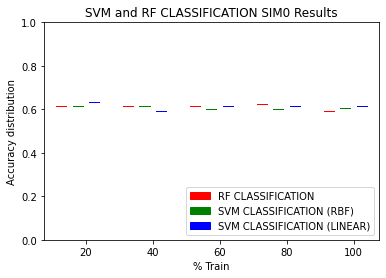

In [44]:
output_file = os.path.abspath('./DataReadyForML/Sim0Output.csv')
genomes_matrix_file = os.path.abspath('./DataReadyForML/Sim0GenomesMatrix.csv')
analysis_type = 'CLASSIFICATION' # REGRESSION or CLASSIFICATION
indices = [0,1,2]

# Number of permutations we need
num_permutations = 1

data_processor = MachineLearningDataProcessingService(num_permutations)
data_processor.performMachineLearningOnSIM0(output_file, genomes_matrix_file, analysis_type, indices)

In [4]:
# create genomes SIM1

Average accuracy for round 1 of matrix permutations: 0.64

Average accuracy for round 1 of matrix permutations: 0.64

Average accuracy for round 1 of matrix permutations: 0.64

INFO:__main__:Average accuracy for round 1 of matrix permutations: 0.64

Memory usage for PID 29776: 520.79: MB
Memory usage for PID 29776: 520.79: MB
Memory usage for PID 29776: 520.79: MB
INFO:__main__:Memory usage for PID 29776: 520.79: MB
Total accuracy for all rounds of matrix permutations with 20.0 percent split: 0.64
Total accuracy for all rounds of matrix permutations with 20.0 percent split: 0.64
Total accuracy for all rounds of matrix permutations with 20.0 percent split: 0.64
INFO:__main__:Total accuracy for all rounds of matrix permutations with 20.0 percent split: 0.64
Average accuracy for round 1 of matrix permutations: 0.568

Average accuracy for round 1 of matrix permutations: 0.568

Average accuracy for round 1 of matrix permutations: 0.568

INFO:__main__:Average accuracy for round 1 of matrix p

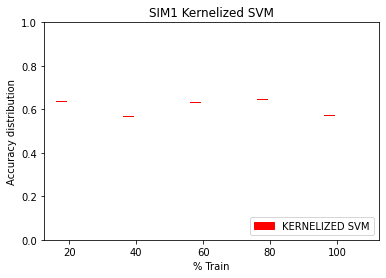

In [43]:
# ML on SIM1 genomes
output_file = os.path.abspath('./DataReadyForML/Sim0Output.csv')
sim1_similarity_matrix_file = os.path.abspath('./DataReadyForML/Sim1SimilarityMatrixfinal.csv')
analysis_type = 'CLASSIFICATION' # REGRESSION or CLASSIFICATION

num_permutations = 1

data_processor = MachineLearningDataProcessingService(num_permutations)
data_processor.performMachineLearningOnSIM1(output_file, sim1_similarity_matrix_file, analysis_type)